# Evaluating the spaCy NER model

## Configuring Environment

In [48]:
import json
import random
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np

import spacy
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from spacy.tokens import DocBin

### Setting Constants

In [49]:
TRAINED_MODEL_DIR = Path("./trained_models/")
RAW_DATA_FILE = Path("./../raw_data/train.json")

# Shortlisted Models
MODEL_SHORTLIST = [
    "model-1000-80(70_30)_20-A/",
    "model-1000-80(70_30)_20-D/",
    "model-B-06/",
    "model-B-01/",
    "model-C-00/",
    "model-C-01/",
    "model-C-05/",
    "model-C-03/",
]

# Encode labels as integers
PII_MAP = {
    "EMAIL": 0,
    "ID_NUM": 1,
    "NAME_STUDENT": 2,
    "PHONE_NUM": 3,
    "STREET_ADDRESS": 4,
    "URL_PERSONAL": 5,
    "USERNAME": 6,
    "O": 7,  # "O" is a special label for non-entities
}
# Reverse mapping for decoding
REV_PII_MAP = {v: k for k, v in PII_MAP.items()}

### Loading Test Data

In [50]:
# Prepare test data
with RAW_DATA_FILE.open("r", encoding="utf-8") as f:
    data = json.load(f)
random.seed(42)
random.shuffle(data)
test_data = data[4000:]

# Create a blank model for the English language
nlp = spacy.blank("en")

TEST_DATA = DocBin()
for document in test_data:
    text = ""
    current_pos = 0
    prediction = []
    current_entity = None

    # Rebuild the text from tokens and whitespace
    for token, has_space, label in zip(
        document["tokens"], document["trailing_whitespace"], document["labels"]
    ):
        # Calculate the start and end positions of the token
        start = current_pos
        end = start + len(token)
        text += token
        current_pos += len(token)

        if has_space:
            text += " "
            current_pos += 1

        # Check label to update entity annotations
        if label.startswith("B-"):
            # Save the previous entity if any
            if current_entity:
                prediction.append(current_entity)

            # Extract label type without BIO prefix
            label_type = label.split("-", 1)[1]
            current_entity = (start, end, label_type)

        elif label.startswith("I-") and current_entity:
            # Update the end of the current entity if label is continuation
            _, _, label_type = current_entity
            current_entity = (current_entity[0], end, label_type)

        else:
            # Save the previous entity if it's the end of an entity
            if current_entity:
                prediction.append(current_entity)
                current_entity = None

    # Ensure the last entity is added if the document ends with an entity
    if current_entity:
        prediction.append(current_entity)

    # Create a Doc object and set its entities
    doc = nlp.make_doc(text)
    ents = [
        doc.char_span(start, end, label=label)
        for start, end, label in prediction
        if doc.char_span(start, end, label=label) is not None
    ]
    doc.ents = ents

    # Add processed document to DocBin
    TEST_DATA.add(doc)

### Defining Functions

In [51]:
def predict_model(model: Path, test_data: DocBin):
    """Predicts entities using the trained model and returns the actual and predicted entities."""
    # Load the trained model
    print(f'Loading model "{model}"...')
    nlp = spacy.load(model)

    # Load the test docs
    test_docs = list(test_data.get_docs(nlp.vocab))

    entities = {"actual": [], "predicted": []}

    print("Predicting entities...")
    for doc in test_docs:
        # Gather the actual and predicted entities
        actual_entities = [(ent.start, ent.end, ent.label_) for ent in doc.ents]
        predicted_entities = [
            (ent.start, ent.end, ent.label_) for ent in nlp(doc.text).ents
        ]

        actual_index = 0
        predicted_index = 0

        # print(f"\nTOTAL A: {len(actual_entities)}, P: {len(predicted_entities)}")
        while actual_index < len(actual_entities) and predicted_index < len(
            predicted_entities
        ):
            # print(f"Actual: {actual_index}, Predicted: {predicted_index}")
            actual_start, actual_end, actual_label = actual_entities[actual_index]
            predicted_start, predicted_end, predicted_label = predicted_entities[
                predicted_index
            ]

            # False negative
            if actual_start < predicted_start:
                # print("False negative")
                entities["actual"].append(actual_label)
                entities["predicted"].append("O")
                actual_index += 1
                continue

            # False positive
            if actual_start > predicted_start:
                # print("False positive")
                entities["actual"].append("O")
                entities["predicted"].append(predicted_label)
                predicted_index += 1
                continue

            # if actual_start == predicted_start:
            # True positive
            if actual_end == predicted_end:
                # print("True positive")
                entities["actual"].append(actual_label)
                entities["predicted"].append(predicted_label)
                actual_index += 1
                predicted_index += 1
                continue

            # if actual_start == predicted_start:
            # actual entity is shorter than predicted entity
            if actual_end < predicted_end:
                # print("Actual < predicted")
                entities["actual"].append(actual_label)
                entities["predicted"].append(predicted_label)
                actual_index += 1
                predicted_index += 1
                # Keep adding actual entities until we reach the end of the predicted entity
                while actual_end < predicted_end:
                    # print(f"Adding actual entity {actual_index}...")
                    actual_index += 1
                    if actual_index < len(actual_entities):
                        actual_start, actual_end, actual_label = actual_entities[
                            actual_index
                        ]
                    else:
                        break
                continue

            # if actual_start == predicted_start:
            # actual entity is longer than predicted entity
            if actual_end > predicted_end:
                # print("Actual > predicted")
                entities["actual"].append(actual_label)
                entities["predicted"].append(predicted_label)
                actual_index += 1
                predicted_index += 1
                # Keep adding predicted entities until we reach the end of the actual entity
                while actual_end > predicted_end:
                    # print(f"Adding predicted entity {predicted_index}...")
                    predicted_index += 1
                    if predicted_index < len(predicted_entities):
                        predicted_start, predicted_end, predicted_label = (
                            predicted_entities[predicted_index]
                        )
                    else:
                        break
                continue
    print("Done predicting entities...")

    # Convert to numpy arrays
    for key in entities:
        label_list = [PII_MAP[label] for label in entities[key]]
        entities[key] = np.array(label_list, dtype=np.uintc)

    return entities

## Finding Best Model

Using F-1 Score as benchmark

### Score All Models

In [ ]:
all_model_results = []
best_score = -1
best_model = None

print(f"Evaluating {len(MODEL_SHORTLIST)} models...")

for model in MODEL_SHORTLIST:
    prediction = predict_model(TRAINED_MODEL_DIR / model, TEST_DATA)
    scores = classification_report(
        prediction["actual"], prediction["predicted"], output_dict=True
    )
    report = classification_report(prediction["actual"], prediction["predicted"])
    all_model_results.append((model, scores, report, prediction))

    current_score = scores["weighted avg"]["f1-score"]
    print(current_score, best_score)
    if current_score > best_score:
        best_score = current_score
        best_model = (model, scores, report, prediction)

print("Done evaluating models...")


### Identify Best Model

In [58]:
print(f"Best model: {best_model[0]}")
class_report = best_model[2]
predictions = best_model[3]


Best model: model-C-01/


### Print Classification Report

In [59]:
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.93      0.97        30
           2       0.97      0.93      0.95       430
           5       1.00      0.93      0.96        28
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00        11

    accuracy                           0.91       512
   macro avg       0.66      0.63      0.65       512
weighted avg       0.95      0.91      0.93       512



### Plot Confusion Matrix

Labels: {'EMAIL': 0, 'ID_NUM': 1, 'NAME_STUDENT': 2, 'PHONE_NUM': 3, 'STREET_ADDRESS': 4, 'URL_PERSONAL': 5, 'USERNAME': 6, 'O': 7}
Plotting confusion matrix...


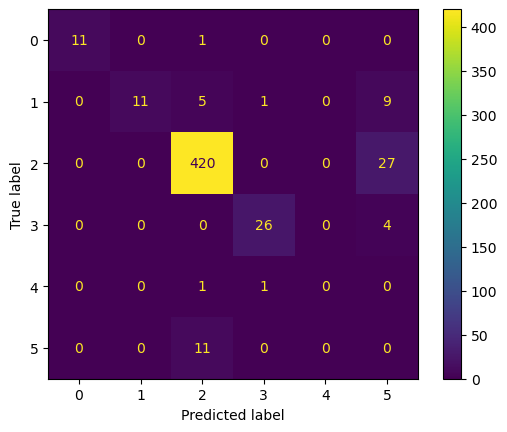

In [60]:
# Display the labels used in the confusion matrix
print(f"Labels: {PII_MAP}")

print("Plotting confusion matrix...")
cm = confusion_matrix(prediction["actual"], prediction["predicted"])
ConfusionMatrixDisplay(cm).plot()

### Plot Actual vs Predicted

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting scatter plot...


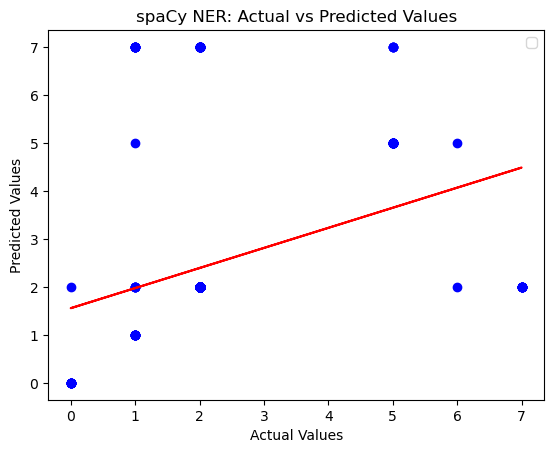

In [77]:
print("Plotting scatter plot...")

plt.scatter(prediction["actual"], prediction["predicted"], color="blue")

# make the line of best fit
coefficients = np.polyfit(prediction["actual"], prediction["predicted"], 1)
m, c = coefficients
fit = (m * prediction["actual"]) + c
plt.plot(prediction["actual"], fit, color="red")

# Label the graph
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("spaCy NER: Actual vs Predicted Values")

# Plot the legend outside the graph
plt.legend()

plt.show()


### Precision vs Recall

Plotting scatter plot...


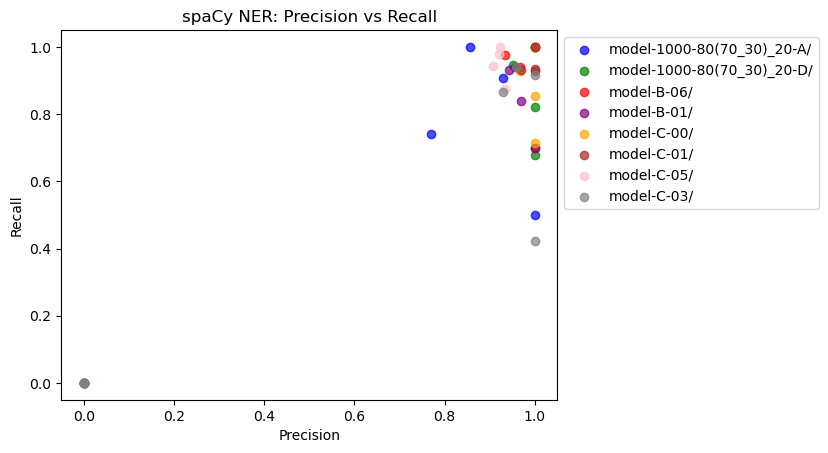

In [80]:
print("Plotting scatter plot...")

colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "gray"]
for (model, score, report, prediction), color in zip(all_model_results, colors):
    precision = [
        score[f"{label}"]["precision"] if f"{label}" in score else 0.0
        for label in REV_PII_MAP
    ]
    recall = [
        score[f"{label}"]["recall"] if f"{label}" in score else 0.0
        for label in REV_PII_MAP
    ]

    plt.scatter(
        precision,
        recall,
        label=model,
        alpha=0.5,
        color=color,
    )

# Label the graph
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("spaCy NER: Precision vs Recall")

# Plot the legend outside the graph
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.show()